## Imports

In [1]:
# To embed plots in the notebooks
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np # numpy library
import scipy.linalg as lng # linear algebra from scipy library
from sklearn import preprocessing as preproc # load preprocessing function

# seaborn can be used to "prettify" default matplotlib plots by importing and setting as default
import seaborn as sns
sns.set() # Set searborn as default

## Load dataset

In [2]:
prostatePath = 'Prostate.txt'

T = np.loadtxt(prostatePath, delimiter = ' ', skiprows = 1, usecols=[1,2,3,4,5,6,7,8,9])

y = T[:, 0]
X = T[:,1:]

[n, p] = np.shape(X)

def normalize(X):
    '''
    Function for normalizing the columns (variables) of a data matrix to unit length.
    Returns the normalized data and the L2 norm of the variables 
    
    Input  (X) --------> The data matrix to be normalized 
    Output (X_pre)-----> The normalized data matrix 
    Output (d) --------> Array with the L2 norms of the variables 
    '''
    d = np.linalg.norm(X,axis=0,ord=2)  # d is the euclidian lenghts of the variables 
    d[d==0]=1                           # Avoid dividing by zero if column L2 norm is zero 
    X_pre = X / d                       # Normalize the data with the euclidian lengths
    return X_pre,d                      # Return normalized data and the euclidian lengths

# Our chosen normalization centers and normalize the variables of a data matrix to unit length.
# We first center our data
X_pre = X - np.mean(X,axis=0)
y_pre = y - np.mean(y,axis=0)

# And then we normalize the variables of the data matrix to unit length 
X_pre,d = normalize(X_pre)

# Checking that the variables (columns) are normalized to unit length
np.linalg.norm(X_pre,axis=0)

array([1., 1., 1., 1., 1., 1., 1., 1.])

## 1 Perform model selection for ridge regression (for the prostate data set):
> (a) Consider using ridge-regression solutions for the prostate data set. What is a suitable range for the shrinkage parameter $λ$ in which to search for an optimal solution in?

In [3]:
def ridgeMulti(X, _lambda, p, y):
    inner_prod = np.linalg.inv(X.T @ X + _lambda * np.eye(p,p))
    outer_prod = X.T @ y
    betas = inner_prod @ outer_prod
    return betas

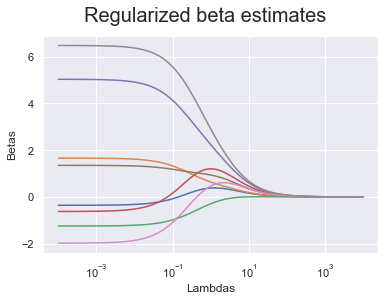

In [4]:
k = 100; # try k values of lambda
lambdas = np.logspace(-4, 4, k)

betas = np.zeros((p,k))
    
for i in range(k):
    betas[:, i] = ridgeMulti(X_pre, lambdas[i], p, y_pre)
    
plt.figure()
plt.semilogx(lambdas, betas.T )
plt.xlabel("Lambdas")
plt.ylabel("Betas")
plt.suptitle("Regularized beta estimates", fontsize=20)
plt.show()

What is a suitable range for $λ$ in which to search for an optimal solution?

> (b) Select a suitable value for the regularization parameter using K-fold cross-validation. Plot the resulting optimal value of lambda on a plot of the parameter trace (i.e. a plot of the $\hat{β}_j$s as a function of $λ$).

>> (i) Try one of the common choices K = 5 and K = 10, and run the cross- validation a couple of times. Which would you prefer and why?
*Hint: To do Crossvalidation create a vector of length n that contains equal amounts of numbers from 1 to K and permute that vector.*

In [5]:
def centerData(data):
    
    mu = np.mean(data,axis=0)
    data = data - mu
    
    return data, mu

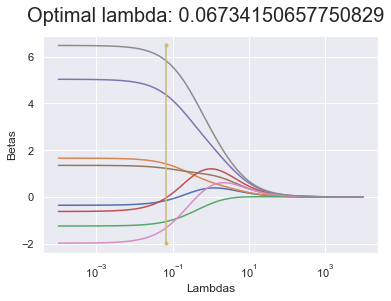

In [6]:
K = 10

#Create a vector of length n that contains equal amounts of numbers from 1 to K
I = np.asarray([0] * n)
for i in range(n):
    I[i] = (i) % K + 1

#Permute that vector. 
I = I[np.random.permutation(n)]

lambdas = np.logspace(-4, 4, k)
MSE = np.zeros((10, 100))

for i in range(1, K+1):
    #Select the train/test data in this fold
    XTrain = X[i != I, :]
    yTrain = y[i != I]
    XTest = X[i == I, :]
    yTest = y[i == I]
    
    #Normalize
    yTrain, mu = centerData(yTrain); # center training response
    yTest = yTest-mu; # use the mean value of the training response to center the test response
    
    XTrain, mu = centerData(XTrain); # center training data
    XTest = XTest-mu; # use the mean value of the training data to center the test data
    
    XTrain,d = normalize(XTrain) # normalize training data
    XTest = XTest / d # normalize test data using euclidian lengths of train data columns
    
    
    #Fit ridgeregression
    for j in range(100):
        beta = ridgeMulti(XTrain, lambdas[j], p, yTrain)
        MSE[(i - 1), j] = np.mean((yTest - np.matmul(XTest, beta)) ** 2)

        
meanMSE = np.mean(MSE, axis = 0)
jOpt = np.argsort(meanMSE)[0]
lambda_OP = lambdas[jOpt]


# Remember excact solution depends on a random indexing, so results may vary
# I reuse the plot with all the betas from 1 a) and add a line for the optimal value of lambda
plt.figure()
plt.semilogx(lambdas, betas.T )
plt.xlabel("Lambdas")
plt.ylabel("Betas")
plt.suptitle(f"Optimal lambda: {lambda_OP}", fontsize=20)
plt.semilogx([lambda_OP, lambda_OP], [np.min(betas), np.max(betas)], marker = ".")
plt.show()

Where should you normalize your data?

(ii) What is the value of K corresponding to leave-one-out cross-validation?

> (c) Find a suitable value of $λ$ using the one-standard-error rule. What is the differ- ence between the two strategies (cross-validation and cross-validation with one- standard-error-rule)?

In [7]:
seMSE = np.std(MSE, axis = 0) / np.sqrt(K)
J = np.where(meanMSE[jOpt] + seMSE[jOpt] > meanMSE)[0]
j = int(J[-1:])
Lambda_CV_1StdRule = lambdas[j]
print("CV lambda with 1-std-rule %0.2f" % Lambda_CV_1StdRule)

CV lambda with 1-std-rule 0.63


> (d) Select suitable values for the regularization parameter using the AIC and BIC criteria (cf. 7.5-7.7 in ESL). What are the advantages and disadvantages of using cross-validation vs. information criteria?

In [8]:
[n, p] = np.shape(X)

# Linear solver
beta_ols, _, rnk, s = lng.lstsq(X_pre, y_pre)

# Using the mean squared error (MSE) of a low bias model (OLS) as the estimate for the noise variance
s2 = np.mean((y_pre - X_pre @ beta_ols)**2) 
s  = np.sqrt(s2)

D = np.zeros(100)
AIC = np.zeros(100)
BIC = np.zeros(100)

for j in range(100):
    beta_ridge = ridgeMulti(X_pre, lambdas[j], p,y_pre)
    
    inner = np.linalg.inv(X_pre.T @ X_pre + lambdas[j] *np.eye(p))
    outer = (X_pre @ inner) @ X_pre.T
    D[j] = np.trace(outer)
    
    e = y - X_pre @ beta_ridge
    err = np.sum(e ** 2) / n
    AIC[j] = err + 2 * D[j] / n * s ** 2
    BIC[j] = n / (s ** 2) * (err + np.log(n) * D[j] / n * s ** 2)

jAIC = np.argsort(AIC)[0]
jBIC = np.argsort(BIC)[0]

print("AIC at %0.2f" % lambdas[jAIC])
print("BIC at %0.2f" % lambdas[jBIC])

AIC at 0.05
BIC at 0.14


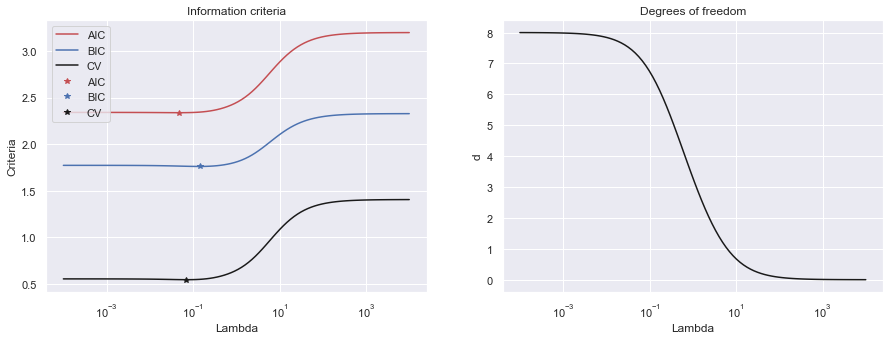

In [9]:
#plot different methods Information criteria: AIC BIC CV
fig, axs = plt.subplots(1, 2, figsize=(15,5))
axs[0].set_title('Information criteria')
_ = axs[0].semilogx(lambdas,AIC,'-r',label='AIC')
axs[0].semilogx(lambdas,BIC/300,'-b',label='BIC')
axs[0].semilogx(lambdas,meanMSE,'-k',label='CV')
axs[0].semilogx(lambdas[jAIC],np.min(AIC),'*r',label='AIC')
axs[0].semilogx(lambdas[jBIC],np.min(BIC)/300,'*b',label='BIC')
axs[0].semilogx(lambdas[jOpt],np.min(meanMSE),'*k',label='CV')
axs[0].legend()
axs[0].set_xlabel('Lambda')
axs[0].set_ylabel('Criteria')

#plot the degree of freedom
axs[1].semilogx(lambdas,D,'-k');
axs[1].set_title('Degrees of freedom');
axs[1].set_xlabel('Lambda');
axs[1].set_ylabel('d');

> (e) Use the bootstrap to estimate the variance of the parameters of the solution $(β)$ for each value of lambda in exercise 1a. Plot the variance estimates as a function of lambda. What do you notice?

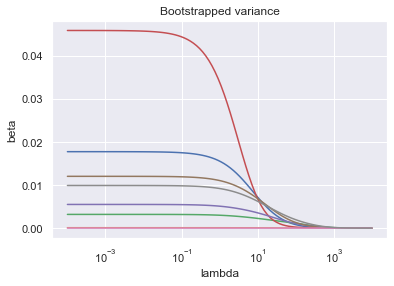

In [10]:
NBoot = 100
Beta = np.zeros((p, len(lambdas), NBoot))

for i in range(NBoot):
    I = np.random.randint(0, n, n)
    XBoot = X[I, :]
    yBoot = y[I]
    for j in range(100):
        Beta[:, j, i] = ridgeMulti(XBoot, lambdas[j], p, yBoot)

stdBeta = np.var(Beta, axis = 2)
plt.figure()
for i in range(8):
    plt.semilogx(lambdas, stdBeta[i,:])
plt.title("Bootstrapped variance")
plt.ylabel("beta")
plt.xlabel("lambda")
plt.show()